# import packages

In [2]:
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import xarray as xr
import time

plt.rcParams.update({'font.size': 22})

# define model and load trained parameters

In [3]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Upsample(scale_factor=2, mode='nearest'),
                    torch.nn.Conv2d(kernel_size=3, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
#                     torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) ## padding?
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Upsample(scale_factor=2, mode='nearest'),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True) ### false should work?
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [4]:
model = UNet(in_channel = 1, out_channel = 1)
model.load_state_dict(torch.load('./models/vort_cs'))

<All keys matched successfully>

# use model to reconstruct ten snapshots of test region data

In [5]:
SPredNorm = np.zeros((10, 1440, 720))
depth = -0
for ind in range(80,90):
    etaTemp = (xr.load_dataarray(f"../CNN_surface/dataCollection2/Eta_anomaly_snap/Eta_{ind}")).isel(XC=slice(1280,2000), YC=slice(280,1720)).values[()]
    xData = np.expand_dims(etaTemp, axis=0)
    
    SPred = np.zeros( (1,1440,720) )
    mask = np.zeros( (1440,720) )
    stride = 5
    region_size = 64
    t0 = time.time()
    
    for i in range(0, 720-region_size+1, stride):
        
        for j in range(0, 1440-region_size+1, stride):
            model.eval()
            SPred[0, j:j+region_size, i:i+region_size] += np.squeeze(model( torch.tensor(np.reshape(xData[:, j:j+region_size, i:i+region_size], (1, 1, region_size, region_size))) ).detach().numpy())
            mask[j:j+region_size,i:i+region_size] += 1
    
    SPredNorm[ind-80,:,:] = np.divide( SPred, mask )
    t1 = time.time()
    print(ind - 80, t1-t0)

In [7]:
# load target data 
yData = np.zeros((10, 1440, 720))
for day in range(80,90):
    vortTemp = xr.load_dataarray(f"dataCollection2/vort_{day}")
    yData[day-80, :, :] = vortTemp.isel(XC=slice(1280,2000), YC=slice(280,1720)).values[()]

# visualize an example of target and reconstruction

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


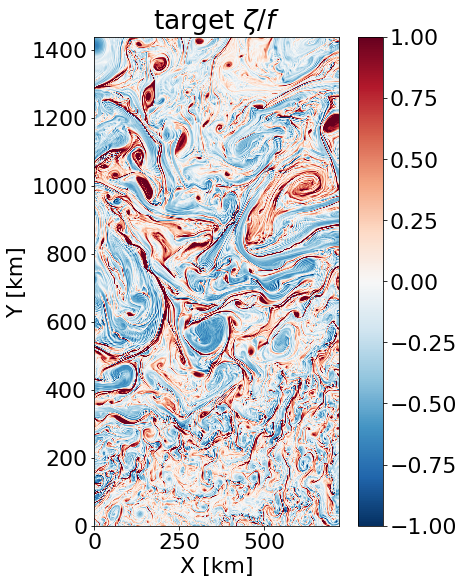

In [24]:
fig, ax = plt.subplots(figsize=(7,9))
im = ax.pcolormesh(np.arange(720), np.arange(1440), yData[0,:,:], vmax=1,vmin=-1,cmap ='RdBu_r', rasterized=True)
ax.set_xlabel("X [km]")
ax.set_ylabel("Y [km]")
ax.set_aspect('equal')
ax.set_title('target $\zeta/f$')
fig.colorbar(im)

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


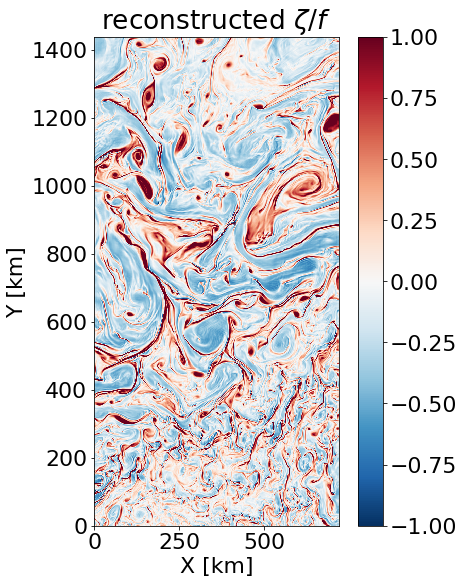

In [22]:
fig, ax = plt.subplots(figsize=(7,9))
im = ax.pcolormesh(np.arange(720), np.arange(1440), SPredNorm[0,:,:], vmax=1,vmin=-1,cmap ='RdBu_r', rasterized=True)
ax.set_xlabel("X [km]")
ax.set_ylabel("Y [km]")
ax.set_aspect('equal')
ax.set_title('reconstructed $\zeta/f$')
fig.colorbar(im)

# calculate correlation and prediction skill against target

In [8]:
from scipy.stats.stats import pearsonr   

In [14]:
for day in range(10):
    truth = yData[day,:,:].flatten()
    pred =  SPredNorm[day,:,:].flatten()
    truth = truth[np.isfinite(pred)]
    pred = pred[np.isfinite(pred)]
    print("day ", day+1)
    print("correlation :", pearsonr(truth, pred)[0])
    skill = 1 - (((truth - pred)**2).mean()/(truth**2).mean())**(0.5)
    print("prediction skill :", skill)

day  1
correlation : 0.9358898651032379
prediction skill : 0.6472415450279213
day  2
correlation : 0.940242790143179
prediction skill : 0.658715032309002
day  3
correlation : 0.9413895932819386
prediction skill : 0.6621834024249289
day  4
correlation : 0.9414429903349503
prediction skill : 0.6623193436309507
day  5
correlation : 0.9443903423125342
prediction skill : 0.6701724973941894
day  6
correlation : 0.9402812028980334
prediction skill : 0.6587730146953568
day  7
correlation : 0.9400992223979783
prediction skill : 0.6586247286142451
day  8
correlation : 0.9404371066509029
prediction skill : 0.6595049176501746
day  9
correlation : 0.9381681460847601
prediction skill : 0.6533945910028177
day  10
correlation : 0.9421697466691759
prediction skill : 0.6640258955500447
